<a href="https://colab.research.google.com/github/diperezbgit/IA-FUNDAMENTALS/blob/main/TAREA_2/TAREA_2_HC_SA_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vehicle Routing Problem (VRP) para Optimización de Rutas en Conexiones Eléctricas
### Se tiene una cuadrilla encargada de atender un conjunto de conexiones eléctricas distribuidas en diferentes distritos. El objetivo es optimizar el tiempo total de atención mediante la determinación del orden óptimo en que la cuadrilla debe visitar cada punto de conexión.




# Carga y visualización de imagen GIS de asignación ordenes de trabajo


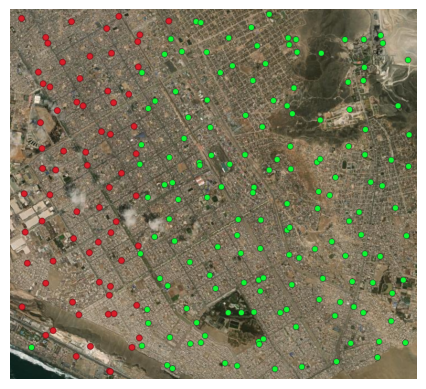

In [360]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO

url = 'https://raw.githubusercontent.com/diperezbgit/IA-FUNDAMENTALS/main/TAREA_2/cnx_gis.png'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

plt.imshow(img)
plt.axis('off')  # Quita los ejes
plt.show()


# Importamos el archivo de ubicación de ordenes de **trabajo**



In [361]:
import pandas as pd
import numpy as np
#  obtenemos al archivo que contiene la informacion sobre las conexiones y ditancias entre ellas
path = r"https://raw.githubusercontent.com/diperezbgit/IA-FUNDAMENTALS/refs/heads/main/TAREA_2/cnx_cuadri02.csv"
df_long = pd.read_csv(path)
# par las pruebas usamos solo 70 puntos
df_reduced = df_long.iloc[:70, :70]
df_reduced


,id,y,x
0,0,8.651913e+06,286690.715164
1,1,8.651592e+06,287093.287133
2,2,8.651016e+06,286976.587931
3,3,8.651502e+06,287134.107559
4,4,8.650819e+06,287052.401729
...,...,...,...
65,65,8.646584e+06,288652.465776
66,66,8.646433e+06,288531.950857
67,67,8.646025e+06,288170.717954
68,68,8.651641e+06,288669.414069


# Funcion plot

In [362]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

def plot_tsp(nodes, route):
    """
    Plot the TSP nodes and route.

    Parameters:
    - nodes: List of tuples containing the coordinates of each node.
    - route: List of node indices representing the TSP route.
    """
    x = [node[0] for node in nodes]
    y = [node[1] for node in nodes]

    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='blue', zorder=2)  # Plot nodes


    for i in range(len(route) - 1):
        node1 = route[i]
        node2 = route[i + 1]
        plt.plot([nodes[node1][0], nodes[node2][0]], [nodes[node1][1], nodes[node2][1]], color='red', zorder=1)  # Plot route

    # Connect the last node to the first node to form a loop
    node1 = route[-1]
    node2 = route[0]
    plt.plot([nodes[node1][0], nodes[node2][0]], [nodes[node1][1], nodes[node2][1]], color='red', zorder=1)  # Plot route

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('TSP Nodes and Route')
    plt.grid(True)
    plt.show()

def plot_tsp_2(nodes, route, ax):
    """
    Plot the TSP nodes and route on the given axis.

    Parameters:
    - nodes: List of tuples containing the coordinates of each node.
    - route: List of node indices representing the TSP route.
    - ax: matplotlib axis to plot on.
    """
    x = [node[0] for node in nodes]
    y = [node[1] for node in nodes]

    ax.scatter(x, y, color='blue', zorder=2)  # Plot nodes

    for i in range(len(route) - 1):
        node1 = route[i]
        node2 = route[i + 1]
        ax.plot([nodes[node1][0], nodes[node2][0]], [nodes[node1][1], nodes[node2][1]], color='red', zorder=1)

    # Connect last node to first to form loop
    node1 = route[-1]
    node2 = route[0]
    ax.plot([nodes[node1][0], nodes[node2][0]], [nodes[node1][1], nodes[node2][1]], color='red', zorder=1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('TSP Nodes and Route')
    ax.grid(True)

# Hill Climbing

In [363]:
def fitness(sol,TSP):
  distance = 0
  for i in range( len(sol) - 1 ):
    distance = distance + TSP[ sol[i]  ][ sol[i+1]  ]
  return distance

def get_neighbors(sol):
  neighbors = []
  for i in range(len(sol) - 1):
    for j in range( i + 1, len(sol) ):
      new_sol = sol.copy()
      new_sol[i], new_sol[j] = new_sol[j], new_sol[i]
      neighbors.append(new_sol)
  return neighbors

def hill_climbing(num_cnx,positions,TSP):
  # step 1: Solucion inicial
  current_solution = np.array(range(num_cnx))
  np.random.shuffle(current_solution)
  sol_init = current_solution
  #plot_tsp(positions, current_solution)

  while True:
    #print("Iteration...")
    # step: generar vecinos
    neighbors = get_neighbors(current_solution)
    best_neighbor = min(neighbors, key=lambda current_solution: fitness(current_solution, TSP))

    #print("current_solution", current_solution)
    #print("fitness current_solution", fitness(current_solution,TSP))
    #print("fitness best_neighbor", fitness(best_neighbor,TSP))

    if fitness(best_neighbor,TSP) < fitness(current_solution,TSP):
      current_solution = best_neighbor
    else:
      return current_solution, fitness(current_solution,TSP), sol_init,fitness(sol_init,TSP)

# Simulated Annealing

In [364]:
def fitness(sol,TSP):
  distance = 0
  for i in range( len(sol) - 1 ):
    distance = distance + TSP[ sol[i]  ][ sol[i+1]  ]
  return distance

def random_neighbor(sol):
  i, j = np.random.choice(len(sol), 2, replace=False) # two random indices
  new_sol = sol.copy()
  new_sol[i], new_sol[j] = new_sol[j], new_sol[i]
  return new_sol

def accept(delta, T):
  if delta < 0:
    return True
  else: # damos la opcion de aceotar soluciones malas.
    r = np.random.rand() # random value between [0, 1]
    if r < np.exp(-delta/T):
      return True
    else:
      return False

def simulated_annealing(T_max, T_min, cooling_rate,positions,TSP):
  T = T_max
  initial_solution= np.array(list(range(len(TSP))))
  np.random.shuffle(initial_solution)

  x = initial_solution.copy()
  E = fitness(x,TSP)
  e_list=[]
  sol_init=x

  #print("temperatura:", T)
  #print("x", x)
  #print("E", E, "\n")

  while (T > T_min) :

    #e_list.append(E) # activar esto si se quiere plotear la energia, retornar valor
    x_new = random_neighbor(x)
    E_new = fitness(x_new,TSP)
    delta = E_new - E

    if accept(delta, T):
      x = x_new
      E = E_new

    T = T*cooling_rate
  return x,fitness(x,TSP),sol_init,fitness(sol_init,TSP)

# Ejecución de algoritmos

In [365]:
import time

# Extraer coordenadas como array
N = len(df_reduced) # cantidad de conexiones
positions = df_reduced[['x', 'y']].values
TSP= squareform(pdist(positions, 'euclidean'))



In [366]:
inicio_hc = time.time()
sol_hc,fit_hc,sol_init_hc,fit_init_hc= hill_climbing(N,positions,TSP)
fin_hc = time.time()

#plot_tsp(positions, sol_hc)
print("\n 'good' solution:", sol_hc)
print("\n fitness:",fit_hc)
print("Tiempo de ejecución:",fin_hc-inicio_hc)


 'good' solution: [66 65 62 64 44 43 63 41 42  4  2  0  1  3 16 33 53 18 19  5  6  7  9 23
 21 20 36 38 37 40 28 26 11 10  8 17 15 30 47 69 68 48 50 27 29 45 61 59
 58 49 31 32 35 34 55 51 52 54 56 57 60 39 22 24 25 12 13 14 46 67]

 fitness: 44251.584251544686
Tiempo de ejecución: 8.338287353515625


In [367]:
T_max = 1000
T_min = 0.000001
#T_min = 0.1
cooling_rate = 0.9999

inicio_sa = time.time()
sol_sa, fit_sa,sol_init_sa,fit_init_sa = simulated_annealing(T_max, T_min, cooling_rate,positions,TSP)
fin_sa = time.time()

#plot_tsp(positions, sol_sa)
print("\n 'good' solution:", sol_sa)
print("\n fitness:",fit_sa)
print("Tiempo de ejecución:",fin_sa-inicio_sa)


 'good' solution: [13 14 27 29 45 44 64 65 66 67 46 62 59 54 52 53 33 51 50 48 68 69 47 30
 49 31 15  0  1  3 16 32 18 17  2  4  5 19 35 34 55 56 38 36 20  6  7 21
 23  9 10 11 12 26 28 43 63 41 61 60 57 58 37 39 22  8 25 24 42 40]

 fitness: 31215.12647221866
Tiempo de ejecución: 24.625362634658813


# Resultados

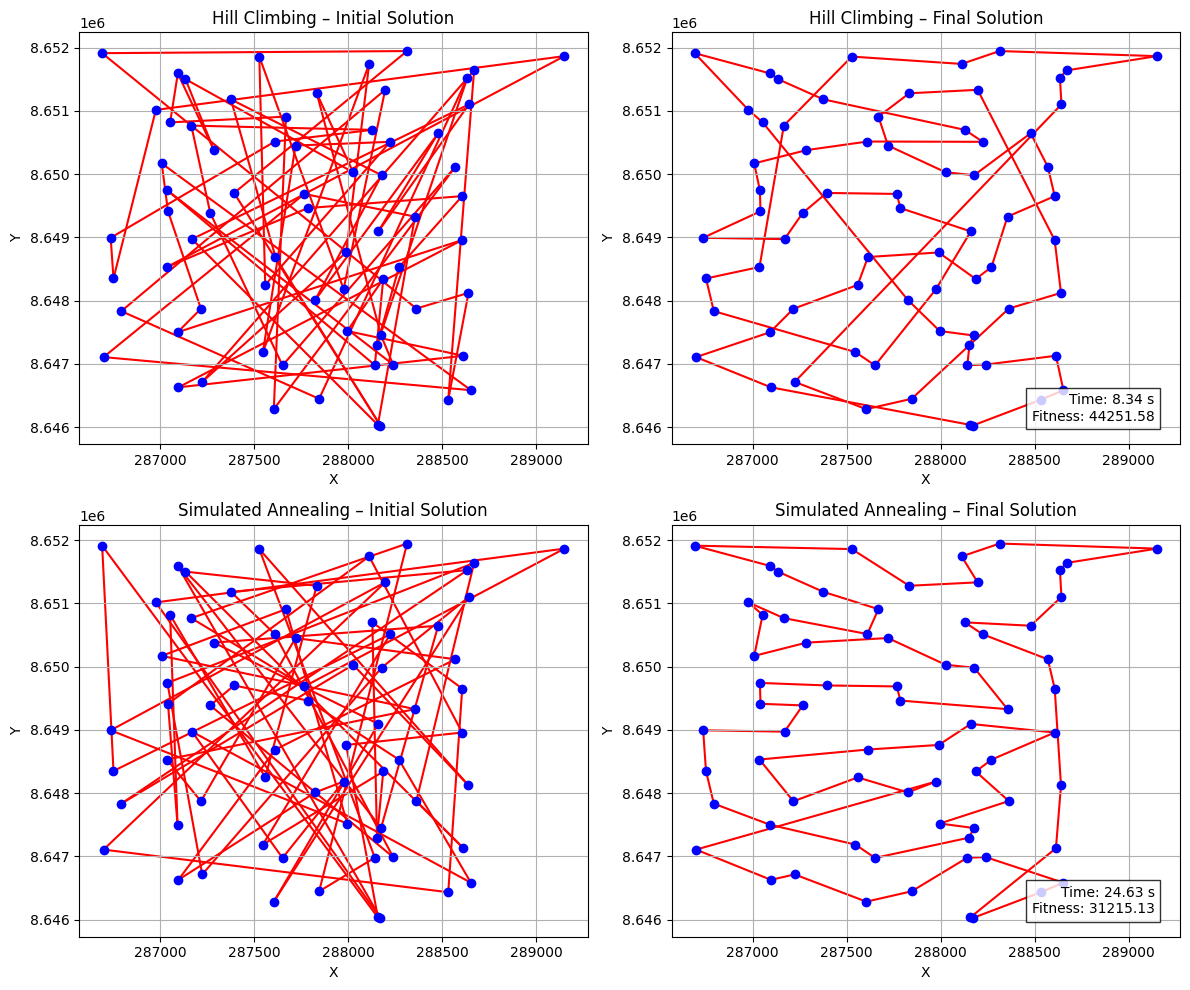

In [373]:

# graficamos
nodes = positions

route1 = sol_init_hc
dist1 = fit_init_hc
route2 = sol_hc
dist2 = fit_hc

route3 = sol_init_sa
dist3 = fit_init_sa
route4 = sol_sa
dist4 = fit_sa

## Subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

plot_tsp_2(nodes, route1, axs[0][0])
axs[0][0].set_title('Hill Climbing – Initial Solution')

plot_tsp_2(nodes, route2, axs[0][1])
axs[0][1].set_title('Hill Climbing – Final Solution')
axs[0][1].text(0.95, 0.05, f'Time: {fin_hc - inicio_hc:.2f} s\nFitness: {fit_hc:.2f}',
               transform=axs[0][1].transAxes,
               fontsize=10, verticalalignment='bottom', horizontalalignment='right',
               bbox=dict(facecolor='white', alpha=0.8))

plot_tsp_2(nodes, route3, axs[1][0])
axs[1][0].set_title('Simulated Annealing – Initial Solution')

plot_tsp_2(nodes, route4, axs[1][1])
axs[1][1].set_title('Simulated Annealing – Final Solution')
axs[1][1].text(0.95, 0.05, f'Time: {fin_sa - inicio_sa:.2f} s\nFitness: {fit_sa:.2f}',
               transform=axs[1][1].transAxes,
               fontsize=10, verticalalignment='bottom', horizontalalignment='right',
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()
